In [20]:
import torch
torch.manual_seed(2)

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn



In [34]:
class System(torch.nn.Module):
    def __init__(self, x0, horizon):
        self.x0 = x0
        self.horizon = horizon
          # Initialize heating state to 0.5 (OFF)

    def step(self, x,u_bin, d = None, neural = True, hard = False):
        """if d is not None:
            u = d[:, 0:+1, :] + u"""
        
        no_disturb = d<1e-5
        override = torch.where(no_disturb, torch.zeros_like(d), torch.ones_like(d))
        # Compute conditions
        on  = x < 8  # ON if too cold
        off = x > 12  # OFF if too hot

        # Apply bang-bang control with hysteresis
        self.heating = torch.where(on,  torch.ones_like(x),
                torch.where(off, torch.zeros_like(x),
                self.heating))

        u = self.heating * (1-override) + u_bin * override

        x = 0.99*x + u - d

        self.u = u.clone()
        return x
    
    def rollout(self, controller, tau = 1,d = None, hard = False, neural = True):
        self.heating = torch.full_like(d[:,0:1,:], 1)
        x = d[:,0:1,:] if d is not None else self.x0.clone()
        xs = x.clone()
        us = torch.zeros(xs.shape[0],1,1)
        self.us_soft = torch.zeros(xs.shape[0],1,1)



        for t in range(1,self.horizon-1):

            u_bin = controller(x,d[:,t:t+1,:],tau = tau,  hard = hard)
            x = self.step(x, u_bin,d[:,t:t+1,:], neural=neural, hard=hard)

            xs = torch.cat((xs, x), 1)
            us = torch.cat((us, u_bin), 1)

            if hard:
                self.us_soft = torch.cat((self.us_soft, controller.u_soft), 1)

        return xs, us
    
class Dataset():    
    def __init__(self, x0, horizon):
        self.x0 = x0
        self.horizon = horizon
        self.batch_size = self.x0.shape[0]

    def generate_data(self):
        d = torch.zeros((self.batch_size, self.horizon, 1))
        d = torch.zeros((self.batch_size, self.horizon, 1))
        d[:, 0, :] = 5*torch.rand((self.batch_size, 1))
        d[:, 0, :] = 10

        # Sample one uniform value per batch in [0.3, 1.0]

        #u = 0.9 + 1.1*torch.rand((self.batch_size, 1, 1))   
        u = torch.rand((self.batch_size, 1, 1))*0.3
        
        d[:, 50:160, :] = 0.3 # Fill from time step 70 onward (inclusive)
         
        return d



In [35]:
class Controller_Gumbel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # output logit
        )


    def forward(self, x,d, tau=1.0, hard=False):
        input = torch.cat((x,d), dim=2)
        logits = self.net(input)

        u = torch.rand_like(logits)

        #g = -torch.log(-torch.log(u))
        
        n = torch.log(u)-torch.log(1-u)
        u_soft = torch.sigmoid((logits+n)/tau)  # shape: [batch, 1]

        self.u_soft = u_soft.clone()    
        if hard == True:
            u_hard = (u_soft > 0.5).float()
            
            return u_hard
        else:
            return u_soft

In [36]:
nb = 400
x0 = torch.zeros((nb,1,1))
#x0[0,0,0] = 10
x_target = 10

horizon = 200

data = Dataset(x0, horizon)
d = data.generate_data()
test_d = data.generate_data()

Epoch 0, Loss: 20.5554
Epoch 150, Loss: 3.0296
Epoch 300, Loss: 2.6790
Epoch 450, Loss: 1.8660
Epoch 600, Loss: 1.5404
Epoch 750, Loss: 1.3613
Epoch 900, Loss: 1.2612
Epoch 1050, Loss: 1.1932
Epoch 1200, Loss: 1.1352
Epoch 1350, Loss: 1.0868
Test Loss: 1.0998


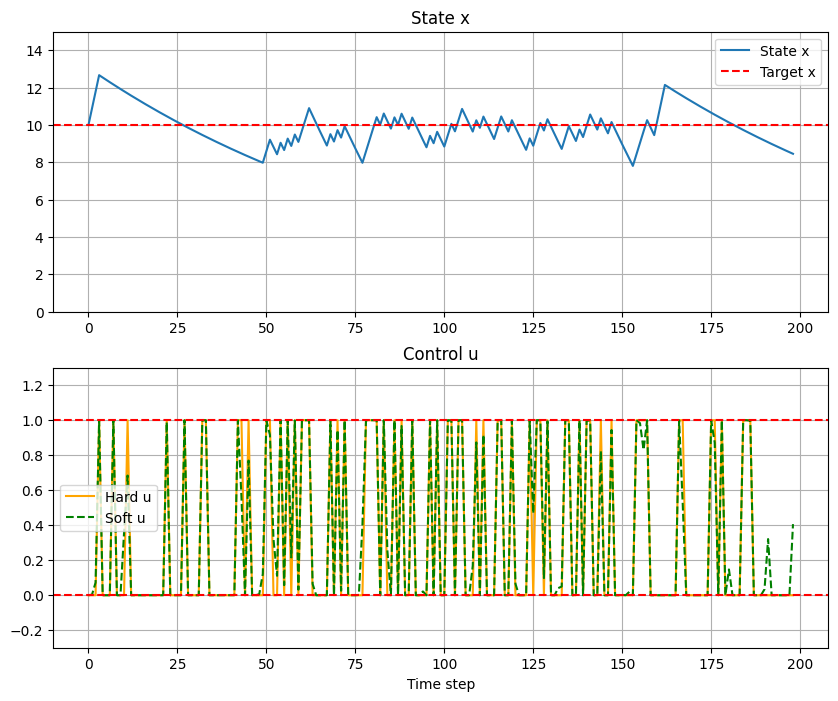

In [37]:
sys = System(x0,horizon)

controller = Controller_Gumbel()


tau_0 = 1.0
alpha = 0.995
tau_min = 0.1

best_loss = float('inf')
best_params = None

num_epochs = 1500
log_epochs = num_epochs // 10
optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    optimizer.zero_grad()

    tau = max(tau_0 * (alpha ** epoch), tau_min)
    #tau = 0.1
    xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

    loss = torch.mean((xs - x_target)**2) 

    loss.backward()
    optimizer.step()

    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = controller.state_dict()

# Load the best parameters
controller.load_state_dict(best_params)
with torch.no_grad():
    x_log, u_log = sys.rollout(controller,tau = tau,d = test_d, hard=True)

loss = torch.mean((x_log- x_target)**2) 
print(f"Test Loss: {loss.item():.4f}")
x_log_01 = x_log.clone()
u_log_01 = sys.us_soft
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy(), label='State x')
"""ax[0].plot(x_log[1,:,:].detach().numpy(), label='State x')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='State x')"""
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].set_title('State x')
ax[0].set_ylim(0, 15)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()



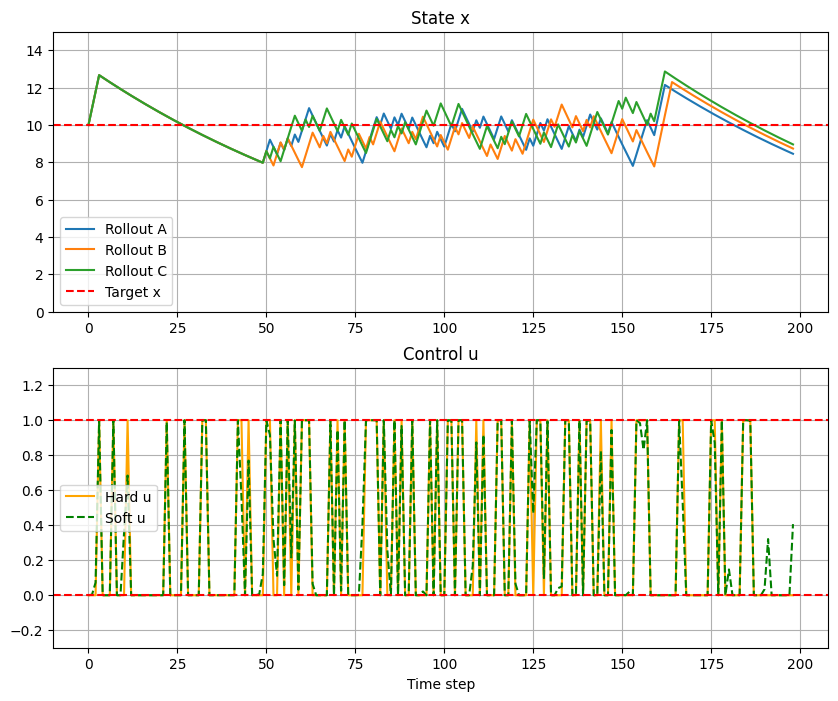

In [38]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy(), label='Rollout A')
ax[0].plot(x_log[1,:,:].detach().numpy(), label='Rollout B')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='Rollout C')
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].set_title('State x')
ax[0].set_ylim(0, 15)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()

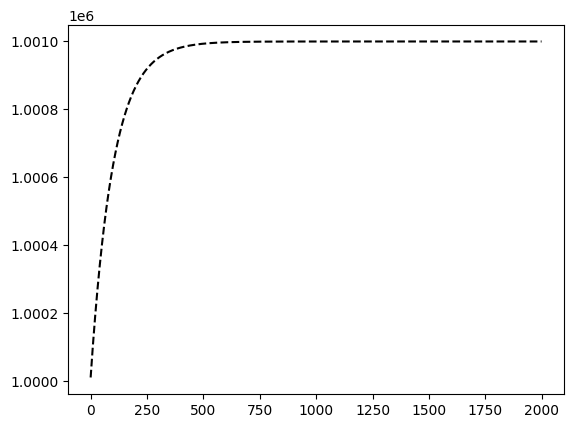

In [44]:
A = 0.99 
B = 10000

x0 = 0.0
x = []
for i in range(2000): 
    x_ = A*x_ + B +10
    x.append(x_)

plt.plot(x, label='Ideal trajectory', linestyle='--', color='black')